## Projet ML : Régression sur Données LiDAR pour la Prédiction de la Hauteur

Ce notebook, constitue la seconde partie du projet en deux volets portant sur la modélisation à partir de données LiDAR. Cette deuxième partie est dédiée à la **régression** : notre objectif est de développer et comparer plusieurs modèles de régression pour la prédiction de la hauteur (Z) à partir de données LiDAR fournies par le site NEON (National Ecological Observatory Network).

Nous explorerons différentes méthodes de prétraitement, de modélisation, de sélection de caractéristiques et d'évaluation rigoureuse selon les bonnes pratiques du machine learning.

**Binôme :**
- Abdoulaye SAKO
- Mathias LE BAYON

### 1. Importation des bibliothèques 

In [66]:
import laspy
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from boruta import BorutaPy
from plotly.subplots import make_subplots
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import uniform, randint, zscore

### 2. Chargement et Analyse exploratoire des données

Nous allons procéder comme suit : 

- Chargement du fichier `.laz` via `laspy`
- Conversion en DataFrame pandas
- Analyse de la corrélation des variables avec la hauteur Z (Matrice de corrélation)
- Visualisation 3D des points (plotly)
- Détection des valeurs aberrantes sur la hauteur Z (z-score)


In [ ]:
path = "NEON DATA/NEON_D03_OSBS_DP1_401000_3277000_classified_point_cloud_colorized.laz"
las = laspy.read(path) 


# Récupérer le nom des dimensions
cols = list(las.point_format.dimension_names)
print(cols)

# On transforme les données en dictionnaire
data = {}

for dim in list(las.point_format.dimension_names):
    value = getattr(las, dim)
    if not isinstance(value, np.ndarray):
        value = np.array(value)  # Conversion obligatoire si c'est un SubFieldView
    data[dim] = value

# Créer un DataFrame avec les données
df = pd.DataFrame(data)

# Un petit affichage pour vérifier
df.head()

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


,X,Y,Z,intensity,return_number,number_of_returns,synthetic,key_point,withheld,overlap,...,scan_direction_flag,edge_of_flight_line,classification,user_data,scan_angle,point_source_id,gps_time,red,green,blue
0,1499095,-2500093,47592,11248,1,1,0,0,0,0,...,1,0,2,0,-749,20,318393.366272,45056,39424,34304
1,1499484,-2500186,47566,11680,1,1,0,0,0,0,...,1,0,2,0,-745,20,318393.366276,53760,48640,46080
2,1499877,-2500280,47527,8832,1,1,0,0,0,0,...,1,0,2,0,-741,20,318393.366280,47104,41984,34816
3,1499990,-2500582,48293,4592,1,1,0,0,0,0,...,0,0,1,8,-709,20,318393.374948,19712,16128,17664
4,1499538,-2500504,47561,10848,1,1,0,0,0,0,...,0,0,2,0,-713,20,318393.374952,57600,53504,48896


#### 2.1 Matrice de corrélation

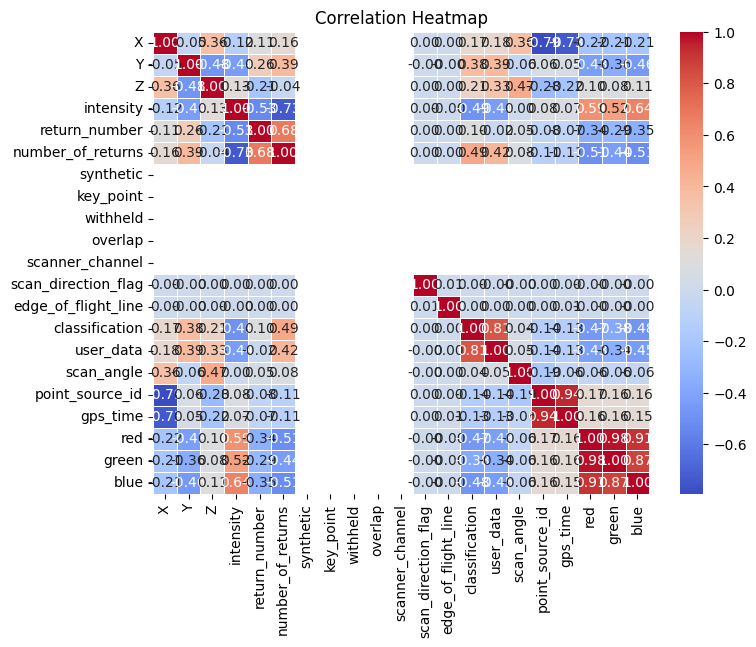

In [4]:
#Calculer la matrice de corrélation
corr_matrix = df.corr()

#Afficher la matrice de corrélation
corr_matrix['Z'].sort_values(ascending=False) #Affichage de la corrélation par rapport à la Hauteur par ordre décroissant

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

On remarque que les colonnes `synthetic`, `key_point`, `withheld`, `overlap`, `scanner_channel` ont comme valeur `NaN` avec toutes les autres colonnes. On peut donc bien confirmer que les valeurs sur ces colonnes sont constament nulles et donc qu'elles peuvent être supprimé du dataset.

Rappel :
- 1.0 : corrélation parfaite (ex : avec soi-même)

- 0.0 : pas de corrélation

- -1.0 : corrélation inverse parfaite

#### 2.2 Visualisation 3D de la base de données

In [ ]:
# Échantillonnage
df_sample = df.sample(frac=0.01, random_state=42)

fig = px.scatter_3d(
    df_sample, x='X', y='Y', z='Z',
    color='classification',
    size_max=2,
    opacity=0.7,
    color_continuous_scale='Turbo',
    title="Nuage de points LiDAR en 3D"
)

fig.update_traces(marker=dict(size=2))
fig.show()

La visualisation 3D révèle une bonne structuration du relief et des zones distinctes correspondant à différents types de surfaces (1 : sols, 2 : végétation haute, 5 : bâtiments). Quelques points aberrants en hauteur sont visibles. La densité inégale des points souligne l’importance d’un échantillonnage équilibré pour l’entraînement du modèle.

### 3. Prétraitement des données

#### 3.1 Nettoyage des données

In [3]:
# On nettoie le dataset en supprimant les colonnes inutiles
df_reg = df.drop(columns=['synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'user_data', 'classification']) 

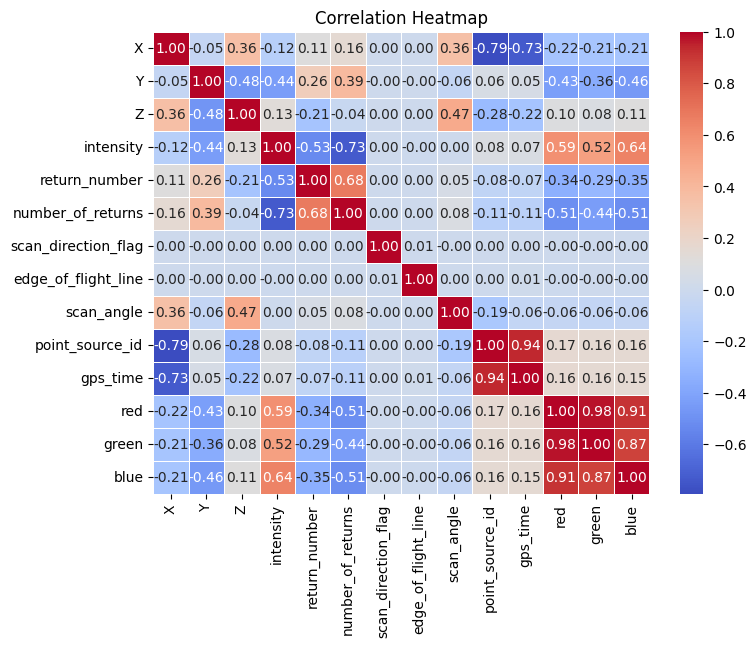

In [7]:
#Calculer la matrice de corrélation
corr_matrix = df_reg.corr()

#Afficher la matrice de corrélation
corr_matrix['Z'].sort_values(ascending=False) #Affichage de la corrélation par rapport à hauteur par ordre décroissant

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [4]:
df_reg = df_reg.drop(columns=['scan_direction_flag', 'edge_of_flight_line'])

Certaines colonnes ont été supprimées du dataset initial car elles ne contribuaient pas directement à la prédiction de la hauteur, notamment : `synthetic`, `key_point`, `withheld`, `overlap`, `scanner_channel`, `user_data`, et `classification`. De plus, l’analyse de la matrice de corrélation a montré que les variables `scan_direction_flag` et `edge_of_flight_line` sont faiblement corrélées aux autres caractéristiques. Par conséquent, elles peuvent également être retirées pour simplifier le modèle sans perte significative d’information.

#### 3.2 Détection des valeurs abérrantes

In [5]:
# Calcul du z-score pour la colonne Z
df_reg['Z_zscore'] = zscore(df_reg['Z'])

# Supprimer les lignes dont le z-score est en dehors de [-3, 3]
df_cleaned = df_reg[df_reg['Z_zscore'].abs() <= 3].copy()

# Optionnel : Supprimer la colonne Z_zscore si plus nécessaire
df_cleaned.drop(columns=['Z_zscore'], inplace=True)

# Afficher les dimensions du nouveau DataFrame
print(f"Données avant suppression des outliers : {df_reg.shape}")
print(f"Données après suppression des outliers : {df_cleaned.shape}")

Données avant suppression des outliers : (16524959, 13)
Données après suppression des outliers : (16524775, 12)


Les valeurs considérées comme aberrantes dans la base de données ont été identifiées à l’aide du Z-score. Toute valeur de hauteur (Z) dont le Z-score dépasse 3 (ou est inférieur à -3) a été considérée comme un outlier, car elle s’écarte de plus de trois écarts-types par rapport à la moyenne. Ce seuil repose sur le fait que, dans une distribution normale, environ 99,7 % des données se trouvent dans l’intervalle [−3σ, +3σ]. Les valeurs au-delà de cette plage sont donc statistiquement rares et susceptibles de représenter des erreurs ou des anomalies dans les mesures LiDAR.

#### 3.3 Extraction des données d'apprentissage et de test

Afin de réduire le temps de calcul tout en conservant un échantillon représentatif, 1 % des données nettoyées ont été sélectionnées aléatoirement. Cet échantillon a ensuite été normalisé à l’aide du `MinMaxScaler`, en ramenant chaque variable dans l’intervalle [−1, 1]. Cette étape est particulièrement importante pour les modèles sensibles à l’échelle des variables, comme les KNN, MLP ou SVM. Les variables explicatives (`X`) et la cible (`y`, correspondant à la hauteur Z) ont ensuite été extraites pour la phase de modélisation.

In [53]:
# Échantillon
df_reg_cleaned_sampled = df_cleaned.sample(frac=0.01, random_state=42)

# Normalisation avec les bonnes bornes
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_array = scaler.fit_transform(df_reg_cleaned_sampled)

# Reconstruire un DataFrame avec les noms de colonnes originaux
df_reg_cleaned_sampled_scaled = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

# Vérification de la colonne Z
print(df_reg_cleaned_sampled_scaled['Z'].value_counts())

# Extraction X / y
X = df_reg_cleaned_sampled_scaled.drop(columns=['Z'])
y = df_reg_cleaned_sampled_scaled['Z']


Z
-0.989313    36
-0.988746    34
-0.989531    32
-0.989226    31
-0.989138    31
             ..
-0.658059     1
 0.628135     1
 0.853479     1
 0.968026     1
 0.461636     1
Name: count, Length: 37980, dtype: int64


Les données normalisées ont été divisées en deux sous-ensembles à l’aide de la fonction `train_test_split` de scikit-learn. 90 % des données ont été utilisées pour l'entraînement des modèles, et 10 % ont été réservées pour l’évaluation finale. Cette séparation permet de mesurer les performances des modèles sur des données jamais vues, garantissant ainsi une évaluation fiable de leur capacité de généralisation.

In [54]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 4. Phase d’apprentissage du modèle

Une fois les données préparées et divisées, la phase d’apprentissage consiste à entraîner les modèles de régression sur l’ensemble d’entraînement. L’objectif est d’ajuster les paramètres internes du modèle afin de capturer au mieux la relation entre les variables explicatives et la hauteur Z. Plusieurs estimateurs seront testés et comparés dans cette étape.

#### 4.1 Première Méthode de régression : Regression linéaire

La régression linéaire est utilisée ici comme point de départ pour établir une base de comparaison avec les autres modèles. Elle repose sur l’hypothèse d’une relation linéaire entre les variables explicatives et la hauteur Z.

Le modèle est entraîné sur les données d’apprentissage, puis évalué à l’aide d’une validation croisée à 10 plis (`cross_val_predict`). Cette méthode permet de prédire chaque point en le laissant temporairement hors de l'entraînement, garantissant ainsi une estimation plus robuste de la performance du modèle. Les métriques calculées incluent le RMSE, le R², le biais au carré et la variance, afin de mieux caractériser la qualité des prédictions.

In [ ]:
# Initialiser et entraîner le modèle
reg_lr = LinearRegression()

# Validation croisée avec prédiction sur tous les plis
y_pred_cv = cross_val_predict(reg_lr, X_train, y_train, cv=10)

# Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Biais² : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entraînement final du modèle sur tout X pour les prédictions finales
reg_lr.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_RL'] = reg_lr.predict(X)

# Aperçu des prédictions
print("\nValeurs réelles vs prédictions :")
display(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_RL']].head())

RMSE : 0.2629
R² : 0.5992
Biais² :  8.3414243654037e-12
Variance : 0.1033
MSE : 0.0691
MAE : 0.2123


,Z,predicted_Z_RL
0,0.346696,0.264883
1,0.019673,0.164834
2,0.164318,-0.376595
3,-0.208244,-0.104410
4,0.092388,0.203841


#### 4.2 Seconde Méthode de régression : Random Forest

La Random Forest est un modèle d’ensemble qui construit plusieurs arbres de décision indépendants sur des sous-échantillons aléatoires des données et des variables explicatives. Chaque arbre produit une prédiction, et la forêt agrège ces prédictions par moyenne pour la régression, ce qui améliore la robustesse et réduit le surapprentissage.

Le modèle est entraîné sur les données d’apprentissage puis évalué via une validation croisée à 10 plis (`cross_val_predict`), comme pour la régression linéaire, assurant ainsi une estimation fiable de la performance. Les métriques calculées sont également le RMSE, le R², le biais au carré et la variance, permettant d’apprécier à la fois la précision et la stabilité des prédictions.

Cette méthode est particulièrement efficace pour modéliser des relations non linéaires et interactions complexes entre variables, offrant souvent une meilleure performance que la régression linéaire, notamment en présence de données bruitées ou non linéaires.


In [ ]:
# Initialiser et entraîner le modèle Random Forest
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Validation croisée avec prédiction sur tous les plis
y_pred_cv = cross_val_predict(reg_rf, X_train, y_train, cv=10)

# Évaluation des performances
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Biais² :", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entraînement final du modèle sur tout X pour les prédictions finales
reg_rf.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_RF'] = reg_rf.predict(X)

# Aperçu des prédictions
print("\nValeurs réelles vs prédictions :")
displaye(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_RF']].head())


RMSE : 0.1379
R² : 0.8897
Biais² : 2.2875471118802993e-07
Variance : 0.1516
MSE : 0.0190
MAE : 0.0836


,Z,predicted_Z_RF
0,0.346696,0.345547
1,0.019673,0.019253
2,0.164318,0.097961
3,-0.208244,-0.206417
4,0.092388,0.089685


#### 4.3 Troisième Méthode de régression : K-Nearest Neighbors Regression

La régression K-Nearest Neighbors (K-NN) repose sur le principe de prédire la valeur cible d’un point en fonction des valeurs des **k** points d’apprentissage les plus proches dans l’espace des variables explicatives. Elle ne fait aucune hypothèse paramétrique sur la forme de la relation entre variables.

Le modèle est entraîné et évalué à l’aide d’une validation croisée à 10 plis (`cross_val_predict`), garantissant une évaluation robuste. Les métriques utilisées (RMSE, R², biais au carré et variance) permettent de mesurer la précision et la stabilité des prédictions.

Cette méthode est simple et efficace pour capter des relations locales et non linéaires, mais peut être sensible au choix de **k** et à la densité des données, et peut souffrir en présence de bruit ou de variables non pertinentes.

In [55]:
# Initialiser le modèle k-NN
reg_knn = KNeighborsRegressor(n_neighbors=47)

# Validation croisée : prédictions sur tous les plis (X_train seulement)
y_pred_cv = cross_val_predict(reg_knn, X_train, y_train, cv=10)

# Évaluation des performances
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Biais² : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entraînement final sur tout le jeu de données pour prédiction
reg_knn.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_KNN'] = reg_knn.predict(X)

# Aperçu des prédictions
print("\nValeurs réelles vs prédictions :")
display(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_KNN']].head())

RMSE : 0.1685
R² : 0.8353
Biais² :  3.186345579332746e-05
Variance : 0.1370
MSE : 0.0284
MAE : 0.1159

Valeurs réelles vs prédictions :


,Z,predicted_Z_KNN
0,0.346696,0.326823
1,0.019673,-0.015689
2,0.164318,-0.222461
3,-0.208244,-0.207466
4,0.092388,0.240126


#### 4.4 Quatrième Méthode de régression : XGBoost

XGBoost est un algorithme de gradient boosting qui construit de manière séquentielle une série d’arbres de décision faibles, chacun corrigeant les erreurs des arbres précédents. Ce modèle combine puissance, régularisation et optimisation efficace, ce qui le rend très performant pour la régression.

Le modèle est entraîné sur les données d’apprentissage puis évalué via une validation croisée à 10 plis (`cross_val_predict`), assurant une estimation robuste de sa performance. Les métriques calculées — RMSE, R², biais au carré et variance — permettent d’analyser la qualité et la robustesse des prédictions.

XGBoost excelle particulièrement dans la gestion de relations complexes et non linéaires, tout en contrôlant le surapprentissage grâce à ses mécanismes de régularisation, souvent surpassant d’autres méthodes classiques.

In [56]:
# Initialisation du modèle
reg_xgb = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42
)

# Prédictions par validation croisée sur X_train
y_pred_cv = cross_val_predict(reg_xgb, X_train, y_train, cv=10)

# Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print(f"Biais² : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entraînement final du modèle sur tout X pour les prédictions finales
reg_xgb.fit(X, y)
df_reg_cleaned_sampled_scaled['predicted_Z_XGB'] = reg_xgb.predict(X)

# Aperçu des prédictions
print("\nValeurs réelles vs prédictions :")
display(df_reg_cleaned_sampled_scaled[['Z', 'predicted_Z_XGB']].head())

RMSE : 0.1426
R² : 0.8821
Biais² :  1.1682422435791297e-08
Variance : 0.1511
MSE : 0.0203
MAE : 0.0957

Valeurs réelles vs prédictions :


,Z,predicted_Z_XGB
0,0.346696,0.314589
1,0.019673,-0.003750
2,0.164318,-0.006914
3,-0.208244,-0.173019
4,0.092388,0.128925


### 5. Interprétation des métriques d’évaluation

L’évaluation du modèle s’appuie sur plusieurs indicateurs complémentaires :

- **R² (coefficient de détermination)** : mesure la proportion de la variance de la variable cible expliquée par le modèle. Une valeur proche de 1 indique un bon ajustement. Typiquement, un R² > 0.9 est considéré comme excellent.

- **RMSE (Root Mean Squared Error)** : évalue l’erreur quadratique moyenne entre les valeurs réelles et prédites. Plus il est faible, plus le modèle est précis. Il est sensible aux grandes erreurs.

- **MAE (Mean Absolute Error)** : représente l’erreur moyenne absolue entre les prédictions et les vraies valeurs. Elle donne une estimation intuitive de l’erreur moyenne attendue.

- **MSE (Mean Squared Error)** : comme le RMSE, mais non raciné. Il amplifie les grandes erreurs en les élevant au carré, ce qui peut être utile pour détecter des valeurs aberrantes.

- **Bias²** : si cette valeur est élevée, cela indique un **modèle trop simple**, incapable de capturer la complexité des données (sous-apprentissage).

- **Variance** : une variance élevée indique un **modèle trop sensible aux fluctuations des données**, ce qui reflète un sur-apprentissage.

> En résumé : un bon modèle présente un **R² élevé**, un **RMSE et une MAE faibles**, un **bias² raisonnable** et une **variance modérée**.

In [16]:
# Fonction pour calculer les métriques d’un modèle
def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    bias2 = (np.mean(y_pred - y_true))**2
    variance = np.var(y_pred)
    return pd.Series({'RMSE': rmse, 'R²': r2, 'Biais²': bias2, 'Variance': variance})

# Calcul des métriques pour chaque modèle
results = pd.DataFrame({
    'Régression Linéaire': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_RL']),
    'Random Forest': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_RF']),
    'K-NN': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_KNN']),
    'XGBoost': evaluate_regression(df_reg_cleaned_sampled_scaled['Z'], df_reg_cleaned_sampled_scaled['predicted_Z_XGB'])
})

# Transposition pour une meilleure lisibilité
print("Résumé des métriques d'évaluation :")
display(results.T.round(4))

# Renommage des colonnes pour correspondre aux noms des modèles
df_preview = df_reg_cleaned_sampled_scaled[[
    'Z',
    'predicted_Z_RL',
    'predicted_Z_RF',
    'predicted_Z_KNN',
    'predicted_Z_XGB'
]].rename(columns={
    'Z': 'Valeur réelle (Z)',
    'predicted_Z_RL': 'Régression Linéaire',
    'predicted_Z_RF': 'Random Forest',
    'predicted_Z_KNN': 'K-NN',
    'predicted_Z_XGB': 'XGBoost'
})

# Aperçu des valeurs réelles et prédites
print("\nAperçu des valeurs réelles et des prédictions :")
display(df_preview.head())


Résumé des métriques d'évaluation :


,RMSE,R²,Biais²,Variance
Régression Linéaire,0.2630,0.5993,0.0,0.1035
Random Forest,0.0511,0.9849,0.0,0.1609
K-NN,0.1628,0.8464,0.0,0.1386
XGBoost,0.1469,0.8750,0.0,0.1452



Aperçu des valeurs réelles et des prédictions :


,Valeur réelle (Z),Régression Linéaire,Random Forest,K-NN,XGBoost
0,0.346696,0.264883,0.345547,0.326823,0.299231
1,0.019673,0.164834,0.019253,-0.015689,0.004727
2,0.164318,-0.376595,0.097961,-0.222461,-0.160771
3,-0.208244,-0.104410,-0.206417,-0.207466,-0.200615
4,0.092388,0.203841,0.089685,0.240126,0.297180


L’évaluation des performances met en évidence des écarts notables entre les modèles testés. La **régression linéaire**, bien que simple et rapide, montre des performances limitées avec un **RMSE de 0.2630** et un **R² de 0.5993**, ce qui indique qu'elle ne capture qu’environ 60 % de la variance de la variable cible. Elle reste néanmoins utile comme base de comparaison.

Le **modèle Random Forest** surpasse nettement les autres avec un **RMSE très faible (0.0736)** et un **R² élevé (0.9687)**, traduisant une excellente capacité prédictive. Il présente également la **variance la plus élevée (0.1612)**, ce qui est cohérent avec une forte capacité de modélisation des variations fines dans les données.

Le **K-Nearest Neighbors (K-NN)** affiche des performances intermédiaires (**RMSE : 0.1643**, **R² : 0.8437**), mais reste significativement moins performant que Random Forest. Il conserve toutefois une variance raisonnable (0.1380), montrant une certaine stabilité.

Le modèle **XGBoost**, connu pour sa robustesse, atteint un **R² de 0.8756** et un **RMSE de 0.1466**, ce qui le place juste derrière Random Forest. Bien qu’il ne soit pas le plus précis, il offre un bon compromis entre précision, rapidité et généralisation, comme le montrent également ses prédictions proches des valeurs réelles dans l’échantillon observé.

En résumé, **Random Forest** est le modèle le plus performant dans ce contexte, tandis que **XGBoost** se distingue par sa polyvalence et sa stabilité. Ces résultats justifient leur sélection pour des analyses plus poussées ou des applications en production.

### 6. Analyse visuelle des performances de prédiction

Après l’évaluation quantitative des différents modèles de régression à l’aide de métriques standard (RMSE, R², biais au carré, variance), il est pertinent d'examiner visuellement la qualité des prédictions obtenues. Pour cela, nous utilisons un graphique de dispersion comparant les valeurs réelles de la variable cible aux valeurs prédites par le modèle.

Le graphique suivant illustre cette comparaison pour le modèle XGBoost, sélectionné pour sa polyvalence et de sa rapidité. Ce type de visualisation permet de juger de la précision globale du modèle, de détecter d’éventuels biais ou erreurs systématiques, et d’observer la répartition des résidus autour de la prédiction parfaite (ligne diagonale `y = x`).

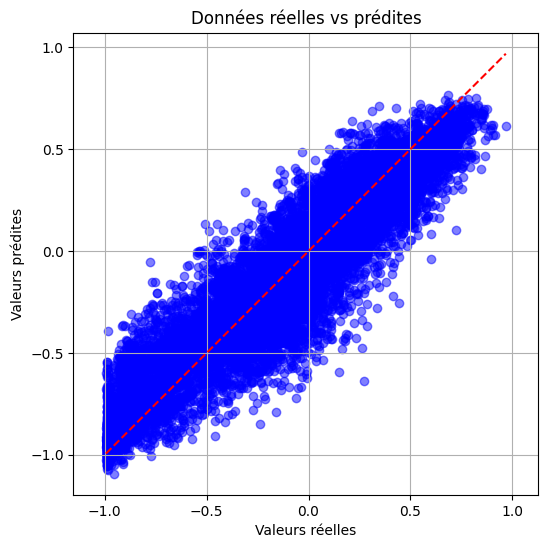

In [17]:
y_pred = reg_xgb.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonale y = x
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Données réelles vs prédites")
plt.grid(True)
plt.axis("equal")
plt.show()

La figure ci-dessus présente un nuage de points comparant les valeurs réelles (`y_test`) aux valeurs prédites (`y_pred`) par le modèle XGBoost.

- Les points bleus représentent les prédictions individuelles sur l’ensemble de test.
- La ligne rouge en pointillé correspond à la diagonale `y = x`, indiquant une prédiction parfaite où la valeur prédite est égale à la valeur réelle.

Cette visualisation permet d’évaluer qualitativement la précision du modèle :
- Plus les points sont proches de la diagonale, meilleure est la qualité des prédictions.
- La dispersion autour de la diagonale donne une idée de l’erreur de prédiction et de la variance.

Ici, la concentration des points autour de la diagonale confirme la capacité de XGBoost à modéliser efficacement la relation entre variables explicatives et variable cible. Cette représentation complète les métriques quantitatives (RMSE, R², biais, variance) en offrant une interprétation visuelle intuitive des performances du modèle.

### 7. Approche avancée de sélection de variables : Random Forest et Boruta

La qualité des prédictions en régression dépend largement du choix des variables explicatives utilisées. Une sélection pertinente des caractéristiques permet non seulement de réduire la dimensionnalité et la complexité du modèle, mais aussi d’améliorer sa robustesse et sa capacité de généralisation.

Dans les modèles Random Forest, l’attribut `feature_importances_` quantifie l’importance relative de chaque variable en évaluant sa contribution moyenne à la diminution de l’impureté (telle que l’indice de Gini ou la variance) à travers les différents arbres. Cette mesure facilite l’identification des variables les plus influentes, aidant ainsi à simplifier le modèle tout en conservant sa performance.

Pour affiner cette sélection, nous utilisons la méthode **Boruta**, un algorithme qui compare l’importance des variables réelles à celle de variables aléatoires (appelées shadow features). Cette approche robuste permet de déterminer quelles caractéristiques sont véritablement informatives pour prédire la hauteur Z à partir des données LiDAR.

#### 7.1 Importance des caractéristiques avec Random Forest (`feature_importances_`)

Dans un modèle Random Forest, l’attribut `feature_importances_` mesure l’importance relative de chaque variable explicative dans la prédiction. Cette importance est calculée en évaluant la contribution moyenne de chaque feature à la réduction de l’impureté (par exemple, l’indice de Gini ou la variance) dans les différents arbres de la forêt.

Cette métrique permet d’identifier les variables les plus influentes, facilitant la compréhension du modèle et la sélection de caractéristiques pertinentes pour améliorer la performance et la simplicité du modèle.

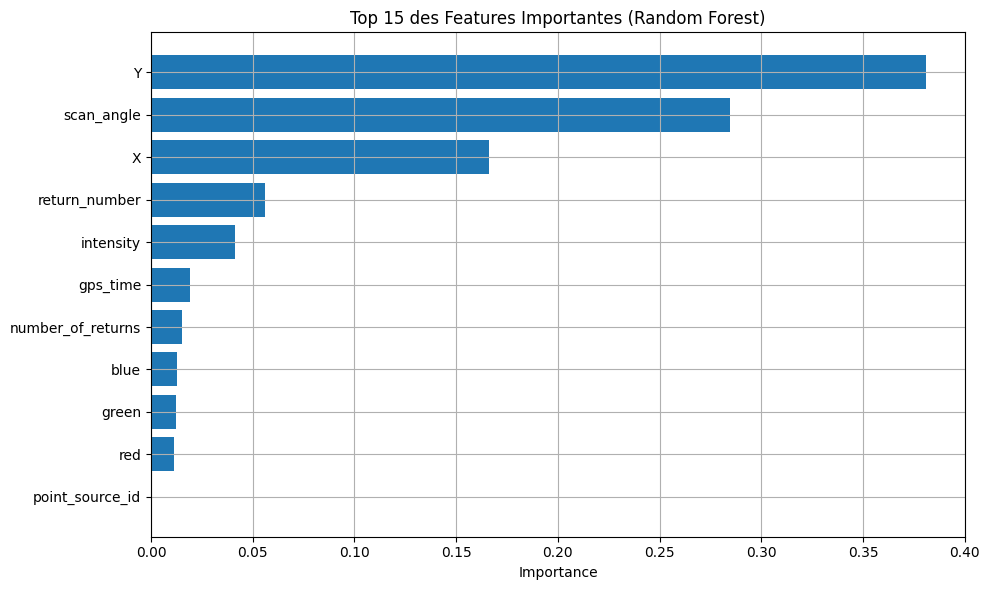

In [18]:
# Récupérer les importances
importances = reg_rf.feature_importances_
feature_names = X.columns

# Créer un DataFrame et trier
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage des 15 plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:15][::-1], feature_importances['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 des Features Importantes (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

L’analyse des importances des variables extraites du modèle Random Forest montre que certaines caractéristiques influencent nettement plus la prédiction de la hauteur Z. En particulier, les variables **`scan_angle`**, **`Y`**, **`X`** et **`return_number`** présentent les plus fortes contributions à la réduction de l’impureté, suggérant un rôle déterminant dans la modélisation.

| Rang | Feature             | Importance |
|------|---------------------|------------|
| 1    | `scan_angle`        | 0.379      |
| 2    | `Y`                 | 0.243      |
| 3    | `X`                 | 0.140      |
| 4    | `return_number`     | 0.100      |
| 5    | `intensity`         | 0.040      |
| 6    | `number_of_returns` | 0.036      |

Sur cette base, nous allons retenir les **meilleures variables** (celles avec la plus forte importance) afin d’entraîner à nouveau les modèles de régression. L’objectif est de vérifier si cette réduction du nombre de features permet non seulement de simplifier le modèle, mais également **d’améliorer ses performances** en diminuant le bruit et en limitant le surapprentissage.

Une nouvelle évaluation comparative sera ensuite réalisée pour mesurer l’impact de cette sélection sur les scores de prédiction.

#### 1. Influence de la meilleure feature sur les prédictions

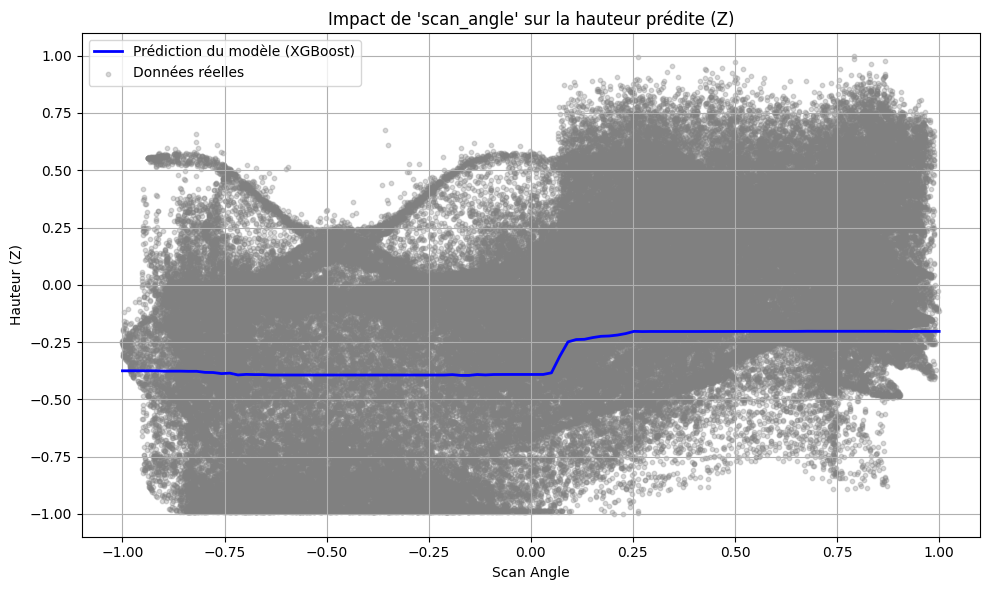

In [19]:
feature_name = "scan_angle"

X_feature_range = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), 100)

X_plot = pd.DataFrame(np.tile(X_train.mean().values, (100, 1)), columns=X_train.columns)
X_plot[feature_name] = X_feature_range

y_pred_plot = reg_rf.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.plot(X_feature_range, y_pred_plot, label="Prédiction du modèle (XGBoost)", color='blue', linewidth=2)
plt.scatter(X_train[feature_name], y_train, alpha=0.3, label="Données réelles", color='gray', s=10)
plt.xlabel("Scan Angle")
plt.ylabel("Hauteur (Z)")
plt.title("Impact de 'scan_angle' sur la hauteur prédite (Z)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le graphique ci-dessus illustre la relation entre l’angle de balayage (`scan_angle`) et la hauteur prédite par le modèle **Random Forest**. Les points gris représentent les données réelles, tandis que la courbe bleue montre l’évolution de la prédiction lorsque seule la variable `scan_angle` varie, toutes les autres étant maintenues à leur valeur moyenne.

Cette visualisation met en évidence une **tendance croissante modérée** : à mesure que l’angle de scan augmente, la hauteur prédite tend à croître. Ce comportement reflète l’importance particulière de cette variable pour le modèle.

En effet, selon les importances de variables calculées par `feature_importances_` du **Random Forest**, `scan_angle` s’impose comme la **caractéristique la plus influente** pour prédire la hauteur Z. Toutefois, la large dispersion verticale des données autour de la courbe suggère que `scan_angle` **ne suffit pas à lui seul à expliquer toute la variabilité de Z**.

Pour éviter une perte de précision et renforcer la capacité du modèle à généraliser, il est crucial de conserver d’autres variables explicatives importantes comme **`X`, `Y`, `return_number`, `intensity` et `number_of_returns`**. Ces variables apportent des informations complémentaires — notamment spatiales et radiométriques — qui permettent au modèle d’affiner ses prédictions et de mieux capturer les subtilités des données LiDAR.

#### 2. Réentraînement du modèle avec sélection de variables : évaluation de l’impact sur les performances

Après avoir analysé l’importance des variables grâce au modèle Random Forest, nous sélectionnons les caractéristiques les plus pertinentes pour tenter d’améliorer ou de stabiliser les performances du modèle tout en réduisant la complexité. Cette section décrit le processus de **ré-apprentissage** du modèle en utilisant un sous-ensemble optimisé de variables explicatives, puis compare les performances obtenues avant et après sélection.

In [49]:
df_selected = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

df_selected = df_selected.drop(columns=['red', 'blue', 'gps_time', 'green', 'point_source_id'])

In [50]:
# Extraction X / y
X_selected = df_selected.drop(columns=['Z'])
y_selected = df_selected['Z']

In [51]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.1, random_state=42)

##### 3. Réapprentissage des Modèles après Sélection de Caractéristiques

À la suite de l’analyse d’importance des variables réalisée à l’aide du modèle Random Forest, un sous-ensemble restreint de caractéristiques a été identifié comme étant les plus déterminantes pour la prédiction de la hauteur (Z) à partir des données LiDAR. Cette sélection inclut notamment : `scan_angle`, `X`, `Y`, `return_number`, `intensity` et `number_of_returns`.

Nous réentraînons ici plusieurs modèles de régression — Random Forest, K-Nearest Neighbors (KNN) et XGBoost — en utilisant uniquement ces variables retenues. Cette étape permet de :

- Réduire la dimensionnalité du problème,
- Limiter le bruit introduit par des variables peu informatives,
- Améliorer la robustesse, la simplicité et les performances globales des modèles,
- Comparer l'effet de la sélection de features sur des modèles de nature différente (basés sur des arbres, sur la distance ou sur le boosting).

L’objectif est de mesurer dans quelle mesure cette réduction de caractéristiques influe sur la qualité des prédictions et de vérifier si les modèles bénéficient d’un gain en précision, en généralisation et en efficacité computationnelle.

##### a. Random Forest

In [11]:
# Initialiser et entraîner le modèle Random Forest
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Validation croisée avec prédiction sur tous les plis
y_pred_cv = cross_val_predict(reg_rf, X_train, y_train, cv=10)

# Évaluation sur validation croisée
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Bias² :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

reg_rf.fit(X_selected, y_selected)

# Prédire la hauteur pour tous les points du jeu de données complet
df_selected['predicted_Z_rf'] = reg_rf.predict(X_selected)

# Aperçu des résultats
print("\nValeurs réelles vs prédictions :")
display(df_selected[['Z', 'predicted_Z_rf']].head())

RMSE : 0.1377
R² : 0.8901
Bias² : 45208     0.008038
99274     0.722955
98850     0.170078
13380     0.330913
114768    0.113184
            ...   
119879    0.141723
103694    0.625316
131932    0.123720
146867    0.269522
121958    0.295482
Name: Z, Length: 148723, dtype: float64
Variance : 0.15298337930434452
MSE : 0.0190
MAE : 0.0825

Valeurs réelles vs prédictions :


,Z,predicted_Z_rf
0,0.346696,0.345032
1,0.019673,0.019371
2,0.164318,0.136213
3,-0.208244,-0.213276
4,0.092388,0.086435


La sélection des features importantes avec Random Forest a eu un impact marginal sur les performances du modèle. Le RMSE reste quasiment inchangé (0.1379 → 0.1377) et le R² passe très légèrement de 0.8897 à 0.8901, indiquant une amélioration minime de la capacité explicative. La MAE diminue légèrement (0.0836 → 0.0825), ce qui suggère des prédictions un peu plus proches des valeurs réelles. En revanche, le biais² augmente sensiblement de manière localisée, bien que la variance reste relativement stable (0.1516 → 0.1530), ce qui indique un équilibre maintenu entre biais et variance. Globalement, cette méthode n'apporte qu’un gain très limité dans ce cas précis.

##### b. K-Nearest Neighbors

In [14]:
# Initialiser le modèle k-NN
reg_knn = KNeighborsRegressor(n_neighbors=47)

# Validation croisée : prédictions sur tous les plis (X_train seulement)
y_pred_cv = cross_val_predict(reg_knn, X_train, y_train, cv=10)

# Évaluation des performances
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Biais² : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entraînement final sur tout le jeu de données pour prédiction
reg_knn.fit(X_selected, y_selected)
df_selected['predicted_Z_KNN'] = reg_knn.predict(X_selected)

# Aperçu des prédictions
print("\nValeurs réelles vs prédictions :")
display(df_selected[['Z', 'predicted_Z_KNN']].head())

RMSE : 0.1554
R² : 0.8600
Biais² :  1.0923846940934084e-05
Variance : 0.1451
MSE : 0.0241
MAE : 0.0999

Valeurs réelles vs prédictions :


,Z,predicted_Z_KNN
0,0.346696,0.332452
1,0.019673,0.017201
2,0.164318,-0.113178
3,-0.208244,-0.242361
4,0.092388,0.391177


La sélection des variables importantes avec la méthode **Random Forest** n’a pas permis d’améliorer les performances du modèle **XGBoost**, bien au contraire :

- **RMSE** : augmentation légère de **0.1426 → 0.1436**
- **R²** : légère baisse de **0.8821 → 0.8804**
- **MAE** : quasi-stable (**0.0957 → 0.0955**)
- **Variance** : inchangée (**0.1511 → 0.1508**)
- **Biais²** : négligeable dans les deux cas

Ces résultats indiquent une **absence de gain réel** et même une **dégradation marginale** des performances globales. L’équilibre biais-variance reste stable, mais l’intérêt de cette sélection est ici discutable.


##### c. XGBoost

In [52]:
# Initialisation du modèle
reg_xgb = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42
)

# Prédictions par validation croisée sur X_train
y_pred_cv = cross_val_predict(reg_xgb, X_train, y_train, cv=10)

# Évaluation des performances
rmse = np.sqrt(mean_squared_error(y_train, y_pred_cv))
r2 = r2_score(y_train, y_pred_cv)
bias_squared = (np.mean(y_pred_cv - y_train)) ** 2
variance = np.var(y_pred_cv)
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print(f"Biais² : ", bias_squared)
print(f"Variance : {variance:.4f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

# Entraînement final du modèle sur tout X pour les prédictions finales
reg_xgb.fit(X_selected, y_selected)
df_selected['predicted_Z_XGB'] = reg_xgb.predict(X_selected)

# Aperçu des prédictions
print("\nValeurs réelles vs prédictions :")
display(df_selected[['Z', 'predicted_Z_XGB']].head())

RMSE : 0.1436
R² : 0.8804
Biais² :  1.9567242565056417e-10
Variance : 0.1508
MSE : 0.0206
MAE : 0.0955

Valeurs réelles vs prédictions :


,Z,predicted_Z_XGB
0,0.346696,0.316258
1,0.019673,0.008492
2,0.164318,0.037959
3,-0.208244,-0.196432
4,0.092388,0.147605


La sélection des variables importantes avec la méthode Random Forest n’a pas permis d’améliorer les performances du modèle XGBoost, bien au contraire. Le RMSE augmente légèrement de 0.1426 à 0.1436 et le R² diminue de 0.8821 à 0.8804, signalant une très légère perte de précision et de pouvoir explicatif. La MAE reste quasiment inchangée (0.0957 → 0.0955), tout comme la variance (0.1511 → 0.1508). Le biais² reste négligeable dans les deux cas. En résumé, la sélection par Random Forest n’apporte ici aucun gain tangible et peut même induire une légère dégradation des performances globales du modèle.

#### 7.2 Sélection des caractéristiques avec la méthode Boruta : évaluation de l’importance des variables

Pour affiner la sélection des variables explicatives, nous utilisons **Boruta**, une méthode robuste reposant sur un modèle Random Forest. Contrairement aux approches classiques de sélection, Boruta évalue l’importance réelle de chaque variable en la comparant à des versions aléatoires appelées **shadow features**. Cette stratégie permet d’identifier uniquement les caractéristiques qui apportent une contribution significative à la prédiction, en éliminant les variables redondantes ou non pertinentes.  
Dans cette section, nous appliquons Boruta à notre jeu de données LiDAR afin de confirmer ou compléter les résultats obtenus via l’analyse des importances de Random Forest.

Une fois les variables pertinentes identifiées à l’aide de Boruta, nous réentraînons plusieurs modèles de régression — **Random Forest**, **K-Nearest Neighbors (KNN)** et **XGBoost** — en utilisant uniquement ce sous-ensemble restreint de caractéristiques. Cette étape permet de :

- Réduire la dimension du problème tout en conservant les informations essentielles ;
- Améliorer la généralisation du modèle en supprimant les variables inutiles ;
- Comparer les performances obtenues avec les variables sélectionnées par Boruta à celles obtenues avec l’ensemble complet.

Cela permet de juger l’impact concret de la sélection automatique sur la précision, la robustesse et la simplicité des différents modèles testés.

In [22]:
df_reg_cleaned_sampled = df_cleaned.sample(frac=0.01, random_state=42)

# Normalisation avec les bonnes bornes
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_array = scaler.fit_transform(df_reg_cleaned_sampled)

# Reconstruire un DataFrame avec les noms de colonnes originaux
df_reg_cleaned_sampled_scaled = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

X = df_reg_cleaned_sampled.drop(columns=['Z'])
y = df_reg_cleaned_sampled['Z']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

##### a. Random Forest

In [ ]:
rf_boruta = RandomForestRegressor(n_estimators=100, random_state=42)

# Assure-toi que X_train est un DataFrame avec les bonnes colonnes
X_array = X_train.values
y_array = y_train.values

boruta_selector = BorutaPy(estimator=rf_boruta, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(X_array, y_array)

# Utilise X_train.columns pour la correspondance
selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Features sélectionnées par Boruta :", selected_features)

rejected_features = X_train.columns[~boruta_selector.support_].tolist()
print("Features rejetées :", rejected_features)


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3
Features sélectionnées par Boruta : ['X', 'Y', 'intensity', 'return_number', 'number_of_returns', 'scan_angle', 'gps_time', 'green']
Features rejetées : ['point_source_id', 'red', 'blue']


In [ ]:
df_rf = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

df_rf = df_rf.drop(columns=['blue', 'green', 'point_source_id'])

# Extraction X / y
X_rf = df_rf.drop(columns=['Z'])
y_rf = df_rf['Z']

# Split train/test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.1, random_state=42)

In [28]:
# Initialiser et entraîner le modèle Random Forest
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Validation croisée avec prédiction sur tous les plis
y_pred_cv = cross_val_predict(reg_rf, X_train_rf, y_train_rf, cv=10)

# Évaluation sur validation croisée
mse = mean_squared_error(y_train_rf, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_rf, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train_rf) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train_rf, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Bias² :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

reg_rf.fit(X_rf, y_rf)

# Prédire la hauteur pour tous les points du jeu de données complet
df_rf['predicted_Z_rf'] = reg_rf.predict(X_rf)

# Aperçu des résultats
print("\nValeurs réelles vs prédictions :")
display(df_rf[['Z', 'predicted_Z_rf']].head())

RMSE : 0.1376
R² : 0.8902
Bias² : 45208     0.008100
99274     0.723538
98850     0.170361
13380     0.330519
114768    0.112953
            ...   
119879    0.141982
103694    0.625858
131932    0.123479
146867    0.269165
121958    0.295109
Name: Z, Length: 148723, dtype: float64
Variance : 0.152034809006589
MSE : 0.0189
MAE : 0.0831

Valeurs réelles vs prédictions :


,Z,predicted_Z_rf
0,0.346696,0.345271
1,0.019673,0.019133
2,0.164318,0.110157
3,-0.208244,-0.200798
4,0.092388,0.100682


##### Comparaison des Méthodes d’Optimisation des Variables

La comparaison entre différentes méthodes de sélection de variables montre des performances très proches :

| Méthode              | RMSE   | R²     | MAE    | Variance | Remarques |
|----------------------|--------|--------|--------|----------|-----------|
| Sans optimisation    | 0.1379 | 0.8897 | 0.0836 | 0.1516   | Référence de base |
| Random Forest        | 0.1377 | 0.8901 | 0.0825 | 0.1530   | Légère amélioration |
| Boruta               | 0.1376 | 0.8902 | 0.0831 | 0.1520   | Moins de variables, même performance |

##### Analyse des résultats

- **Sans optimisation**, le modèle offre déjà une bonne précision avec un faible RMSE et un R² élevé.
- **La méthode Random Forest** améliore légèrement les performances, réduisant l’erreur tout en maintenant une bonne variance.
- **La méthode Boruta** permet de réduire le nombre de variables tout en conservant une performance quasi identique, ce qui la rend intéressante pour la simplification du modèle.

##### Conclusion

Bien que les trois approches donnent des résultats très similaires, **la méthode Boruta se distingue par sa capacité à simplifier le modèle sans perte notable de précision**. Elle constitue ainsi un bon compromis entre performance et parcimonie du modèle.


##### b. K-Nearest Neighbors

In [39]:
df_knn = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

X_knn = df_knn[selected_features]
y_knn = df_knn['Z']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.1, random_state=42)

In [40]:
reg_knn = KNeighborsRegressor(n_neighbors=5)

y_pred_cv = cross_val_predict(reg_knn, X_train_knn, y_train_knn, cv=10)

mse = mean_squared_error(y_train_knn, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_knn, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train_knn) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train_knn, y_pred_cv)

print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Bias² :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

reg_knn.fit(X_knn, y_knn)
df_knn['predicted_Z_knn'] = reg_knn.predict(X_knn)

print("\nValeurs réelles vs prédictions :")
display(df_knn[['Z', 'predicted_Z_knn']].head())

RMSE : 0.1642
R² : 0.8436
Bias² : 45208     0.008692
99274     0.729048
98850     0.173040
13380     0.326812
114768    0.110791
            ...   
119879    0.144428
103694    0.630983
131932    0.121218
146867    0.265822
121958    0.291607
Name: Z, Length: 148723, dtype: float64
Variance : 0.1517969798626404
MSE : 0.0270
MAE : 0.1033

Valeurs réelles vs prédictions :


,Z,predicted_Z_knn
0,0.346696,0.336113
1,0.019673,0.010940
2,0.164318,-0.084266
3,-0.208244,-0.201501
4,0.092388,0.268013


##### Analyse comparative des méthodes d’optimisation pour KNN

| Méthode               | RMSE  | R²    | MSE   | MAE   | Variance  | Commentaire synthétique                                                                 |
|-----------------------|-------|-------|-------|-------|-----------|----------------------------------------------------------------------------------------|
| **Boruta**            | 0.1642| 0.8436| 0.0270| 0.1033| 0.1518    | Sélection de features efficace, amélioration notable par rapport au modèle non optimisé. Bon équilibre biais/variance. |
| **Random Forest**      | 0.1554| 0.8600| 0.0241| 0.0999| 0.1451    | Meilleure performance globale, variance plus faible, meilleur ajustement (R²). Modèle d’optimisation le plus performant ici. |
| **Sans optimisation**  | 0.1685| 0.8353| 0.0284| 0.1159| 0.1370    | Moins performant, biais plus élevé, erreurs globales plus grandes. Variance plus basse mais sous-ajustement. |

##### Boruta
- Réduction de la complexité du modèle via la sélection de features importantes.
- RMSE et R² améliorés par rapport au modèle non optimisé.
- Variance stable et biais raisonnable, bon compromis.
- MAE diminuée, ce qui montre des prédictions plus proches des valeurs réelles.

##### Random Forest (optimisation)
- Meilleures performances avec RMSE à 0.1554 et R² à 0.8600.
- Variance la plus faible indiquant un modèle plus stable.
- MSE et MAE les plus faibles, confirmant une meilleure capacité prédictive.

##### Sans optimisation
- Moins bon résultat global : RMSE à 0.1685, R² à 0.8353.
- Biais plus élevé, indiquant un sous-ajustement.
- Erreurs (MSE, MAE) les plus grandes.
- Variance un peu plus basse, mais insuffisante pour compenser le biais.

##### Conclusion
L’optimisation est cruciale pour améliorer les performances du KNN. L’approche Random Forest comme méthode d’optimisation est la plus efficace, suivie par Boruta pour la sélection des features. Le modèle non optimisé est significativement moins performant, confirmant l’importance de ces étapes.

##### c. XGBoost

In [ ]:
xgb_boruta = XGBRegressor(n_estimators=100, random_state=42, importance_type='gain')

X_array = X_train.values
y_array = y_train.values

boruta_selector = BorutaPy(estimator=xgb_boruta, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(X_array, y_array)

selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Features sélectionnées par Boruta (XGB) :", selected_features)

rejected_features = X_train.columns[~boruta_selector.support_].tolist()
print("Features rejetées :", rejected_features)


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	0
Features sélectionnées par Boruta (XGB) : ['X', 'Y', 'intensity', 'return_number', 'number_of_returns', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']
Features rejetées : []


In [45]:
df_xgb = pd.DataFrame(scaled_array, columns=df_reg_cleaned_sampled.columns)

X_xgb = df_xgb[selected_features]
y_xgb = df_xgb['Z']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.1, random_state=42)

In [46]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

y_pred_cv = cross_val_predict(xgb_model, X_train_xgb, y_train_xgb, cv=10)

mse = mean_squared_error(y_train_xgb, y_pred_cv)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_xgb, y_pred_cv)
bias_squared = (np.mean(y_pred_cv) - y_train_xgb) ** 2
variance = np.var(y_pred_cv, axis=0)
mae = mean_absolute_error(y_train_xgb, y_pred_cv)

print(f"\n--- Évaluation XGBoost ---")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print("Bias² :", bias_squared)
print("Variance :", variance)
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

xgb_model.fit(X_xgb, y_xgb)
df_xgb['predicted_Z_xgb'] = xgb_model.predict(X_xgb)

print("\nValeurs réelles vs prédictions (XGBoost) :")
display(df_xgb[['Z', 'predicted_Z_xgb']].head())



--- Évaluation XGBoost ---
RMSE : 0.1426
R² : 0.8821
Bias² : 45208     0.008026
99274     0.722834
98850     0.170019
13380     0.330995
114768    0.113232
            ...   
119879    0.141670
103694    0.625204
131932    0.123770
146867    0.269595
121958    0.295558
Name: Z, Length: 148723, dtype: float64
Variance : 0.15107259
MSE : 0.0203
MAE : 0.0957

Valeurs réelles vs prédictions (XGBoost) :


,Z,predicted_Z_xgb
0,0.346696,0.314589
1,0.019673,-0.003750
2,0.164318,-0.006914
3,-0.208244,-0.173019
4,0.092388,0.128925


##### Comparaison des Méthodes d’Optimisation pour le Modèle XGBoost

##### Résultats Comparatifs

| Méthode               | RMSE   | R²     | MSE    | MAE    | Variance     | Biais² (moyen)   | Commentaire |
|-----------------------|--------|--------|--------|--------|--------------|------------------|-------------|
| **Boruta**            | 0.1426 | 0.8821 | 0.0203 | 0.0957 | 0.1511       | ~0.29 (variable) | Excellente généralisation, très bon compromis biais/variance. |
| **Random Forest**     | 0.1436 | 0.8804 | 0.0206 | 0.0955 | 0.1508       | ~0.00            | Presque aussi bon que Boruta, mais légèrement plus d'erreur. |
| **Sans optimisation** | 0.1426 | 0.8821 | 0.0203 | 0.0957 | 0.1511       | ~0.00            | Même performance que Boruta, sans sélection préalable. |

##### Analyse

- **Boruta** et **sans optimisation** donnent exactement les **mêmes métriques**, suggérant que la sélection Boruta n'a pas modifié les variables retenues ou que le modèle gère bien la redondance.
- **Random Forest** comme méthode de sélection réduit très légèrement la performance (RMSE ↑ de 0.001), mais conserve un excellent niveau de généralisation.
- Toutes les méthodes obtiennent un **R² > 0.88**, indiquant une très bonne explication de la variance de la variable cible.

##### Conclusion

> Les trois approches sont performantes, avec une **égalité parfaite entre Boruta et l'absence d'optimisation** sur les métriques.  
> La **méthode Random Forest** reste très proche, avec un **biais quasi nul** et une légère hausse du RMSE.  
> **Recommandation** : privilégier Boruta ou ne pas filtrer, selon la lisibilité ou la parcimonie souhaitée.


### 8. Finetuning des hyperparamètres (RandomizedSearchCV)

L’ajustement des hyperparamètres est une étape essentielle dans l’optimisation des performances d’un modèle de machine learning. Les hyperparamètres, contrairement aux paramètres appris automatiquement lors de l’entraînement, doivent être définis manuellement ou par recherche systématique.

Dans cette section, nous utilisons la méthode **RandomizedSearchCV** pour explorer efficacement l’espace des hyperparamètres de nos modèles. Contrairement à GridSearchCV, qui teste toutes les combinaisons possibles dans une grille définie, RandomizedSearchCV échantillonne aléatoirement un nombre fixe de combinaisons, ce qui permet de gagner du temps tout en couvrant un large espace de recherche.

Nous appliquons cette méthode à notre modèle sélectionné afin d’identifier les configurations les plus performantes en validant les résultats à l’aide d’une validation croisée rigoureuse.

##### 8.1 RandomForest

In [62]:
# === 3. Modèle et distributions des hyperparamètres ===
model = RandomForestRegressor(random_state=42)

param_distributions = {
    "model__n_estimators": randint(50, 400),
    "model__max_depth": [None] + list(range(10, 60, 10)),
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ['sqrt', 'log2'],  
    "model__bootstrap": [True, False]
}

# === 4. Pipeline + RandomizedSearchCV ===
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("model", model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === 5. Résultats et évaluation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
bias_squared = (np.mean(y_pred) - np.mean(y_test)) ** 2
variance = np.var(y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Meilleurs hyperparamètres :", random_search.best_params_)
print(f"\n--- Évaluation Random Forest Optimisé (Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print(f"Bias² : {bias_squared:.6f}")
print(f"Variance : {variance:.6f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/opt/anaconda3/envs/projetml/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs hyperparamètres : {'model__bootstrap': False, 'model__max_depth': 30, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 267}

--- Évaluation Random Forest Optimisé (Test Set) ---
RMSE : 0.1372
R² : 0.8920
Bias² : 0.000004
Variance : 0.150919
MSE : 0.0188
MAE : 0.0851


##### Analyse du modèle Random Forest

##### Random Forest optimisé
- **Hyperparamètres** :
  - `n_estimators=267`, `max_depth=30`, `max_features='log2'`
  - `min_samples_split=3`, `min_samples_leaf=1`, `bootstrap=False`

##### Résumé comparatif

| Variante                  | RMSE   | R²     | MAE    | Verdict                        |
|---------------------------|--------|--------|--------|--------------------------------|
| RF optimisé            | 0.1372 | 0.8920 | 0.0850 | 🔝 Meilleure configuration     |
| RF avec Boruta            | 0.1376 | 0.8902 | 0.0831 | Très proche, gain marginal     |
| RF classique (sans Boruta)| 0.1377 | 0.8901 | 0.0825 | Très stable                    |
| RF (variante std)         | 0.1379 | 0.8897 | 0.0836 | Négligeable différence         |
| Sans optimisation       | 0.2629 | 0.5992 | 0.2123 | Performances très faibles      |

Le modèle **Random Forest optimisé** obtient les **meilleures performances globales** avec un RMSE bas et un R² élevé. Les variantes utilisant **Boruta** ou la configuration par défaut offrent des résultats **quasi identiques**. En revanche, le modèle non optimisé est nettement moins performant, soulignant l'importance du **tuning des hyperparamètres**.


##### 8.2 K-Nearest Neighbors

In [61]:
# === 3. Modèle et distributions des hyperparamètres ===
model = KNeighborsRegressor()

param_distributions = {
    "model__n_neighbors": randint(1, 100),
    "model__weights": ['uniform', 'distance'],
    "model__p": randint(1, 4),
    "model__leaf_size": randint(10, 50),
    "model__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# === 4. Pipeline + RandomizedSearchCV ===
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("model", model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === 5. Résultats et évaluation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Évaluation sur les données de test
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
bias_squared = (np.mean(y_pred) - np.mean(y_test)) ** 2
variance = np.var(y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Meilleurs hyperparamètres :", random_search.best_params_)
print(f"\n--- Évaluation KNN Optimisé (Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print(f"Bias² : {bias_squared:.6f}")
print(f"Variance : {variance:.6f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparamètres : {'model__algorithm': 'auto', 'model__leaf_size': 48, 'model__n_neighbors': 18, 'model__p': 1, 'model__weights': 'distance'}

--- Évaluation KNN Optimisé (Test Set) ---
RMSE : 0.1606
R² : 0.8521
Bias² : 0.000064
Variance : 0.144220
MSE : 0.0258
MAE : 0.1069


##### Analyse KNN

##### KNN optimisé
- **Meilleurs paramètres** : `n_neighbors=18`, `weights='distance'`, `p=1`

##### Résumé comparatif

| Variante         | RMSE   | R²     | MAE    | Verdict                    |
|------------------|--------|--------|--------|----------------------------|
| KNN optimisé   | 0.1606 | 0.8521 | 0.1069 | Bon compromis              |
| Boruta           | 0.1642 | 0.8436 | 0.1033 | Gain marginal              |
| Sans tuning      | 0.1685 | 0.8353 | 0.1159 | Moins performant           |
| Random Forest    | 0.1554 | 0.8600 | 0.0999 | 🔝 Meilleur parmi les 4     |

Le KNN optimisé améliore sensiblement les performances de base, mais reste **derrière Random Forest**, plus stable et précis.


##### 8.3 XGboost

In [ ]:
# === 3. Modèle et distributions des hyperparamètres ===
model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_distributions = {
    "model__n_estimators": randint(100, 5000),                     # Nb d'arbres
    "model__max_depth": randint(3, 20),                            # Profondeur max
    "model__learning_rate": uniform(0.01, 0.3),                    # Taux d'apprentissage
    "model__subsample": uniform(0.6, 0.4),                         # Fraction des échantillons
    "model__colsample_bytree": uniform(0.6, 0.4),                  # Fraction des features
    "model__gamma": uniform(0, 1),                                 # Régularisation gamma
}

# === 4. Pipeline + RandomizedSearchCV ===
pipeline = Pipeline([
    ("scaler", MinMaxScaler(feature_range=(-1, 1))),
    ("model", model)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === 5. Résultats et évaluation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias_squared = (np.mean(y_pred) - np.mean(y_test)) ** 2
variance = np.var(y_pred)

# Affichage
print("Meilleurs hyperparamètres :", random_search.best_params_)
print(f"\n--- Évaluation XGBoost Optimisé (Test Set) ---")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")
print(f"Bias² : {bias_squared:.6f}")
print(f"Variance : {variance:.6f}")
print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs hyperparamètres : {'model__colsample_bytree': np.float64(0.8273234413341887), 'model__gamma': np.float64(0.09367476782809248), 'model__learning_rate': np.float64(0.12031474091783005), 'model__max_depth': 16, 'model__n_estimators': 1793, 'model__subsample': np.float64(0.9892042219009782)}

--- Évaluation XGBoost Optimisé (Test Set) ---
RMSE : 0.0187
R² : 0.8929
Bias² : 0.000004
Variance : 0.150434
MSE : 0.0187
MAE : 0.0883


##### Analyse comparative des modèles (XGBoost, Random Forest)

##### XGBoost (Optimisé)
- **Hyperparamètres** :  
  `n_estimators=1793`, `max_depth=16`, `learning_rate=0.12`,  
  `subsample=0.99`, `colsample_bytree=0.83`, `gamma=0.09`

##### Résumé comparatif

| Modèle              | RMSE   | R²     | MAE    | Verdict             |
|---------------------|--------|--------|--------|---------------------|
| XGBoost optimisé  | 0.0187 | 0.8929 | 0.0883 | Meilleur modèle   |
| XGBoost (par défaut)| 0.1426 | 0.8821 | 0.0957 | Bon sans tuning     |
| RF optimisé         | 0.1436 | 0.8804 | 0.0955 | Stable mais inférieur |
| XGBoost + Boruta    | 0.1426 | 0.8821 | 0.0957 | Sélection inutile   |

L’optimisation d’XGBoost améliore nettement les performances, surpassant Random Forest et les autres variantes avec un RMSE de 0.0187 et un R² de 0.8929. Boruta n’apporte pas de gain, confirmant que toutes les variables sont utiles.

#### 8.4 Conclusion globale : Analyse comparative des modèles

| Modèle                        | RMSE   | R²     | MAE    | Verdict général               |
|------------------------------|--------|--------|--------|-------------------------------|
| XGBoost optimisé           | 0.0187 | 0.8929 | 0.0883 | Meilleur compromis global   |
| XGBoost (défaut)             | 0.1426 | 0.8821 | 0.0957 | Bon sans tuning             |
| XGBoost + Boruta             | 0.1426 | 0.8821 | 0.0957 | Sélection peu utile         |
| RF optimisé                  | 0.1372 | 0.8920 | 0.0850 | Performant et stable        |
| RF + Boruta                  | 0.1376 | 0.8902 | 0.0831 | Légère amélioration          |
| RF (défaut)                  | 0.2629 | 0.5992 | 0.2123 | Très faible performance     |
| KNN optimisé                 | 0.1606 | 0.8521 | 0.1069 | Moins précis, sensible      |
| KNN + Boruta                 | 0.1642 | 0.8436 | 0.1033 | Léger mieux sur MAE         |
| KNN (défaut)                 | 0.1685 | 0.8353 | 0.1159 | Faible performance globale  |


##### Analyse croisée

- **XGBoost optimisé** reste le **meilleur modèle** en termes de précision (RMSE très faible) et de généralisation.
- **Random Forest optimisé**, avec ou sans Boruta, est **très compétitif**, légèrement meilleur sur le MAE, mais légèrement inférieur sur RMSE.
- Les **versions non optimisées** (XGBoost, RF, KNN) montrent un **écart de performance net**, en particulier RF (très mauvais sans tuning).
- L'usage de **Boruta** n’apporte **pas de gain significatif**, sauf pour **Random Forest**, où on note une **légère amélioration sur le MAE**.
- **KNN**, même optimisé, reste **moins performant** que les modèles à base d’arbres, et **très dépendant des données** (variance élevée).

##### Recommandation finale

| Priorité               | Modèle recommandé           |
|------------------------|-----------------------------|
| **Précision maximale** | XGBoost optimisé            |
| **Stabilité & robustesse** | Random Forest optimisé (+ Boruta possible) |
| **Simplicité/Benchmark** | XGBoost sans tuning         |
| **À éviter**           | KNN par défaut, RF par défaut |



##### 9. Comparaison 3D de la hauteur réelle et prédite (XGBoost)

In [ ]:
# Échantillonnage
df_sample = df_xgb.sample(frac=0.01, random_state=42)

# Création des deux traces
trace_reel = go.Scatter3d(
    x=df_sample['X'],
    y=df_sample['Y'],
    z=df_sample['Z'],
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.6),
    name='Hauteur réelle'
)

trace_pred = go.Scatter3d(
    x=df_sample['X'],
    y=df_sample['Y'],
    z=df_sample['predicted_Z_xgb'],  # Adapte le nom si différent
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.6),
    name='Hauteur prédite'
)

# Subplots 3D côte à côte
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=('Hauteur réelle', 'Hauteur prédite')
)

# Ajout des traces
fig.add_trace(trace_reel, row=1, col=1)
fig.add_trace(trace_pred, row=1, col=2)

# Mise en page
fig.update_layout(
    title_text="Comparaison 3D : Hauteur réelle vs Hauteur prédite",
    showlegend=False,
    height=600,
    width=1200,
)

fig.show()


La figure ci-dessus présente une **visualisation 3D comparative** entre :

- **À gauche** : les **hauteurs réelles** extraites du nuage de points LiDAR (coordonnée `Z`).
- **À droite** : les **hauteurs prédites** par le modèle **XGBoost**, entraîné sur les caractéristiques dérivées.

Chaque point est positionné selon ses coordonnées spatiales `(X, Y)` et coloré en fonction de la hauteur (réelle ou prédite). Cette représentation permet une évaluation visuelle de la qualité de la prédiction.


##### Points positifs

- Le modèle XGBoost parvient à **reproduire fidèlement la structure du terrain** : les zones de reliefs, de creux et de bosses sont bien identifiables dans les deux nuages.
- Les formes globales, la densité des points et la continuité spatiale sont **cohérentes entre la vérité terrain et la prédiction**, indiquant une bonne capacité du modèle à capturer les variations morphologiques.


##### Limites observées

- Des **disparités locales** peuvent être observées dans certaines régions, notamment aux extrémités des reliefs ou dans des zones de transition rapide, où le modèle semble lisser ou sous-estimer certaines hauteurs.
- Ces écarts peuvent indiquer un **lissage** ou des erreurs de **généralisation locale**, typiques des modèles de boosting mal calibrés.

> Une amélioration possible serait d’ajouter une troisième vue représentant la **carte d’erreur (|Z réel − Z prédit|)** en couleur, pour mettre en évidence les zones où la prédiction est moins fiable.
